In [200]:
%matplotlib inline
import time
import imageio

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image

from IPython.display import clear_output

from lib.CAModel import CAModel
from lib.utils_vis import SamplePool, to_alpha, to_rgb, get_living_mask, make_seed, make_circle_masks

In [201]:
def to_grayscale(x):
    return np.dot(x[..., :3], [0.2989, 0.5870, 0.1140])

In [202]:
def load_emoji(index, path="data/emoji.png"):
    im = imageio.imread(path)
    emoji = np.array(im[:, index*40:(index+1)*40].astype(np.float32))
    emoji /= 255.0
    return emoji

def visualize_batch(x0, x):
    vis0 = to_grayscale(x0)
    vis1 = to_grayscale(x)
    print('batch (before/after):')
    plt.figure(figsize=[15,5])
    for i in range(x0.shape[0]):
        plt.subplot(2,x0.shape[0],i+1)
        plt.imshow(vis0[i])
        plt.axis('off')
    for i in range(x0.shape[0]):
        plt.subplot(2,x0.shape[0],i+1+x0.shape[0])
        plt.imshow(vis1[i])
        plt.axis('off')
    plt.show()

def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.show()

In [203]:
device = torch.device("cpu")
model_path = "models/remaster_1.pth"
#Уменьшил количество эпох в обучении, установил CHANNEL_N = 9, TARGET_PADDING = 8
CHANNEL_N = 9        # Number of CA state channels
TARGET_PADDING = 8   # Number of pixels used to pad the target image border
TARGET_SIZE = 40

lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
n_epoch = 500

BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = 1 #@param "🦎"

EXPERIMENT_TYPE = "Regenerating"
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

C:\Users\Виталий\AppData\Local\Temp\ipykernel_7284\1645380178.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(path)


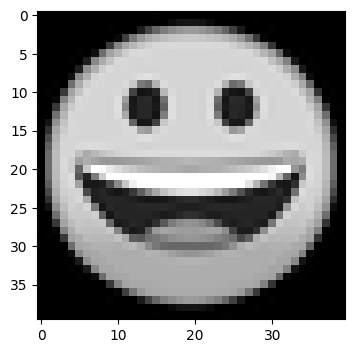

In [204]:
target_img = load_emoji(TARGET_EMOJI)
grayscale_img = to_grayscale(target_img)
plt.figure(figsize=(4,4))
plt.imshow(grayscale_img, cmap='gray', vmin=0, vmax=1)
plt.show()

In [205]:
p = TARGET_PADDING
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32)).to(device)

seed = make_seed((h, w), CHANNEL_N)
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
batch = pool.sample(BATCH_SIZE).x

ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device).to(device)
ca.load_state_dict(torch.load(model_path))

optimizer = optim.Adam(ca.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)

500 loss = 0.10944639146327972
batch (before/after):


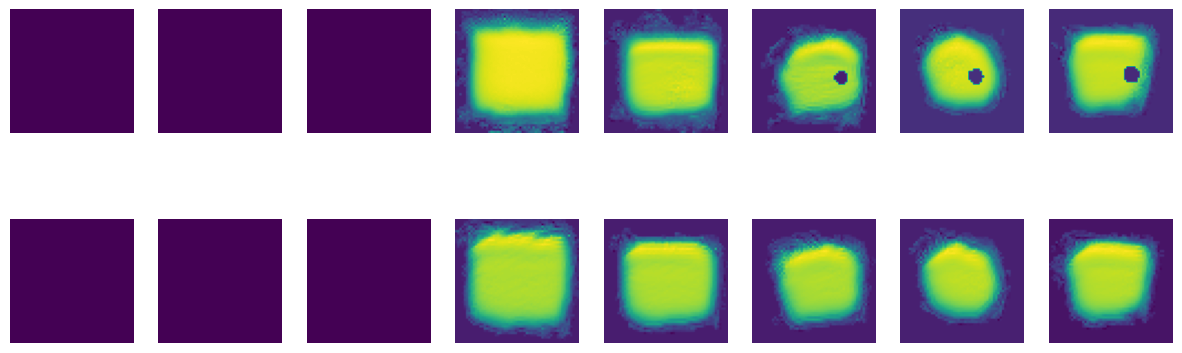

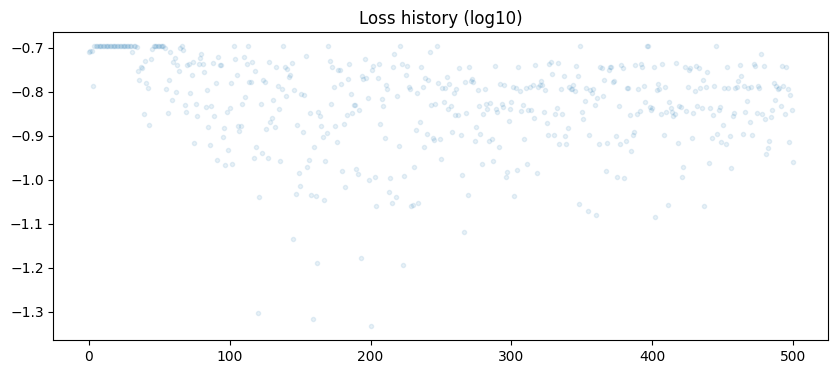

In [206]:
loss_log = []

def train(x, target, steps, optimizer, scheduler):
    x = ca(x, steps=steps)
    loss = F.mse_loss(x[:, :, :, :4], target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    return x, loss

def loss_f(x, target):
    return torch.mean(torch.pow(x[..., :4]-target, 2), [-2,-3,-1])

for i in range(n_epoch+1):
    if USE_PATTERN_POOL:
        batch = pool.sample(BATCH_SIZE)
        x0 = torch.from_numpy(batch.x.astype(np.float32)).to(device)
        loss_rank = loss_f(x0, pad_target).detach().cpu().numpy().argsort()[::-1]
        x0 = batch.x[loss_rank]
        x0[:1] = seed
        if DAMAGE_N:
            damage = 1.0-make_circle_masks(DAMAGE_N, h, w)[..., None]
            x0[-DAMAGE_N:] *= damage
    else:
        x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

    x, loss = train(x0, pad_target, np.random.randint(64,96), optimizer, scheduler)
    
    if USE_PATTERN_POOL:
        batch.x[:] = x.detach().cpu().numpy()
        batch.commit()

    step_i = len(loss_log)
    loss_log.append(loss.item())
    
    if step_i%100 == 0:
        clear_output()
        print(step_i, "loss =", loss.item())
        visualize_batch(x0.detach().cpu().numpy(), x.detach().cpu().numpy())
        plot_loss(loss_log)
        torch.save(ca.state_dict(), model_path)